In [1]:
import os
import pandas as pd

# Define the path to the folder
path = 'RMMS/'

# Get a list of all files in the folder
files = [f for f in os.listdir(path) if f.endswith('.lrps.htm')]

# Initialize an empty list to store DataFrames
dfs = []

# Loop through each file
for file in files:
    # Read HTML tables into a list of DataFrames
    tables = pd.read_html(os.path.join(path, file))
    
    # Combine all tables into a single DataFrame
    df = pd.concat(tables)
    
    # Remove the first row and rows above row 9
    df = df.iloc[9:].reset_index(drop=True)
    
    # Set the correct header using the values from row 9
    df.columns = df.iloc[0]
    
    # Drop the now redundant row 9
    df = df.iloc[1:].reset_index(drop=True)
    
    # Drop the first and last columns
    df = df.iloc[:, 1:-1]
    
    # Add a new column for road number
    road_number = file.split('.')[0]  # Extract road number from file name
    df['road_number'] = road_number
    
    # Append the DataFrame to the list
    dfs.append(df)

# Concatenate all DataFrames into one
combined_df = pd.concat(dfs, ignore_index=True)

# Save the combined DataFrame to a CSV file
combined_df.to_csv('combined_lrps.csv', index=False)


XMLSyntaxError: no text parsed from document (<string>, line 0)

In [ ]:
combined_df.shape
combined_df.to_csv('RMMS/combined_lrps.csv', index=False)

In [ ]:
import pandas as pd

traffic_df = pd.read_csv('traffic.csv')
traffic_df.head()

In [101]:
traffic_df= traffic_df.rename(columns = { 'LRP':'LRP Start', 'Offset': 'Offset Start', 'Chainage':'Chainage Start', 'LRP.1':'LRP End', 'Offset.1': 'Offset End', 'Chainage.1':'Chainage End'})
print(traffic_df.shape)


(2066, 26)


In [102]:
# Combining the different dataframes into one so we have the lat/lon values combined with the AADT values so we can calculate the different economic values for the road parts.  
combined_lrps = pd.read_csv('combined_lrps.csv')

latlonload = pd.merge(traffic_df, combined_lrps, left_on=['LRP Start','road'], right_on=['LRP No', 'road_number'] )

In [103]:
#When merging we got 3 rows of each entry, we have dropped the duplicates below to ensure we do not get double entries.
latlonload = latlonload.drop_duplicates()

In [104]:
#To calculate the economic value of a roadpart, we have to assign economic value to different vehicle types. Afterwards we will multiply these values with the amount of sightings on each road to compute the economic value of a road. The logic behind the values is that for example trucks are able to carry a lot of goods, busses a lot of people and smaller vehicles are more individual focussed, hence the smaller economic impact. It should be noted that these are all estimates as we were unable to find research on the marginal economic impact of these vehicle types. 

# Define economic value vehicles dictionary
economic_value_vehicles = {'Heavy Truck':10, 'Medium Truck': 8, 'Small Truck':7, 'Large Bus':7, 'Medium Bus':6,
                           'Micro Bus':5, 'Utility':3, 'Car':3, 'Auto Rickshaw':2, 'Motor Cycle': 1,
                           'Bi-Cycle':0.5, 'Cycle Rickshaw':1, 'Cart':1}

# Define a function to check if a value can be converted to float
def is_float(x):
    try:
        float(x)
        return True
    except ValueError:
        return False

# Apply the function to each element of the DataFrame
for col in economic_df.columns:
    non_numeric_values = economic_df[col][~economic_df[col].apply(is_float)]
    if not non_numeric_values.empty:
        print(f"Non-numeric values in column '{col}':")
        print(non_numeric_values)

# Drop rows containing 'NS' values because there were rows with only NS values where floats were supposed to be.
latlonload = latlonload[~latlonload.apply(lambda row: (row == 'NS').any(), axis=1)]



In [105]:
# Select columns relevant for economic calculation
economic_df = latlonload.loc[:, 'Heavy Truck':'Cart']

# Convert values to floats
economic_df = economic_df.astype(float)

# Calculate the economic value for each row
latlonload['EVV'] = economic_df.apply(lambda row: sum(row[col] * economic_value_vehicles[col] for col in economic_df.columns if col in economic_value_vehicles), axis=1)

latlonload.tail(10)

,road,name,LRP Start,Offset Start,Chainage Start,LRP End,Offset End,Chainage End,(Km),Heavy Truck,...,Total AADT,(AADT),LRP No,Road Chainage,LRP TYPE,Description,Latitude Decimal,Longitued Decimal,road_number,EVV
6162,Z8909,Char Fession (Int.with R890) - Betua,LRPS,0,0.000,LRP006,952,7.002,7.002,0.0,...,3991.0,3991.0,LRPS,0,Others,Start from R890 at Thana road more char fassion,22.185833,90.76025,Z8909,5192.5
6165,Z8913,Debirchar - Lalmohon (Int.with R890),LRPS,0,0.000,LRPS,11325,11.325,11.325,24.0,...,6344.0,6344.0,LRPS,0,Others,"Start of debir char high school , Lalmohon Bhola",22.396083,90.6886663,Z8913,10778.0
6168,Z8913,Lalmohon (Int.with R890) - Tazumuddin (Int.wit...,LRPS,11325,11.325,LRPS,26505,26.505,15.180,0.0,...,2418.0,2418.0,LRPS,0,Others,"Start of debir char high school , Lalmohon Bhola",22.396083,90.6886663,Z8913,3108.0
6171,Z8915,Bagmara - Bangla Bazar (Int.with R890),LRPS,0,0.000,LRP004,1020,4.350,4.350,0.0,...,3522.0,3522.0,LRPS,0,Others,Start at Bagmara Infront of Launch Ghat.,22.5893886,90.6194716,Z8915,7911.0
6174,Z8915,Bangla Bazar (Int.with R890) - Int.with Z8916,LRP004,1020,4.350,LRP010,1150,10.470,6.120,0.0,...,3117.0,3117.0,LRP004,3.366,Km Post,Inf missing,22.5926941,90.6494719,Z8915,6379.0
6177,Z8915,Int.with Z8916 - Daulatkhan,LRP010,1150,10.470,LRP014,2290,15.660,5.190,0.0,...,3117.0,3117.0,LRP010,9.376,Km Post,Inf missing,22.6011389,90.7048333,Z8915,6379.0
6180,Z8916,Guingerhat (Int.with R890) - Int.with Z8915,LRPS,0,0.000,LRP004,3626,7.626,7.626,0.0,...,2440.0,2440.0,LRPS,0,Others,Start from R890 at Guingerhat Bazar Dhola,22.6254993,90.6617222,Z8916,3553.5
6183,Z8916,Int.with Z8915 - Daulatkhan Bazar,LRP004,3626,7.626,LRP005,6600,11.591,3.965,0.0,...,2440.0,2440.0,LRP004,4,Km Post,Information missing,22.6189716,90.6941108,Z8916,3553.5
6186,Z8943,Tazumuddin (Int.with Z8905) - Fakirhat (Int.wi...,LRPS,0,0.000,LRPS,6446,6.446,6.446,0.0,...,3083.0,3083.0,LRPS,0,Others,Start at intersection of Z8905 /BC joint infro...,22.4264438,90.8494719,Z8943,5651.0
6189,Z8943,Fakirhat (Int.with Z8948) - Kungerhat (Int.wit...,LRPS,6446,6.446,LRPS,8800,8.800,2.354,0.0,...,3083.0,3083.0,LRPS,0,Others,Start at intersection of Z8905 /BC joint infro...,22.4264438,90.8494719,Z8943,5651.0


In [111]:
latlonload = latlonload.rename(columns={'Longitued Decimal':'Longitude Decimal'})
latlonload.sort_values('EVV', ascending=False).head(10)


,road,name,LRP Start,Offset Start,Chainage Start,LRP End,Offset End,Chainage End,(Km),Heavy Truck,...,Total AADT,(AADT),LRP No,Road Chainage,LRP TYPE,Description,Latitude Decimal,Longitude Decimal,road_number,EVV
651,N3,Banani Rail Crossing-Progoti sharani(Left) (Left),LRPS,0,0.000,LRP001a,0,1.810,1.810,45.0,...,82414.0,82414.0,LRPS,0,Others,Start of Road From the End of Banani Rail Cros...,23.814583,90.404306,N3,311371.0
654,N3,Banani Rail Crossing-Progoti sharani(Left) (Ri...,LRPS,0,0.000,LRP001a,0,1.810,1.810,127.0,...,81610.0,81610.0,LRPS,0,Others,Start of Road From the End of Banani Rail Cros...,23.814583,90.404306,N3,309359.0
657,N3,"Progoti sharani-Abdullahpur, Int. with N302 (L...",LRP001a,0,1.810,LRP001a,7247,9.057,7.247,38.0,...,73476.0,73476.0,LRP001a,1.81,"Side Road, Right",Progoti Sharani,23.821777,90.419110,N3,284732.0
660,N3,"Progoti sharani-Abdullahpur, Int. with N302 (L...",LRP001a,0,1.810,LRP001a,7247,9.057,7.247,234.0,...,69068.0,69068.0,LRP001a,1.81,"Side Road, Right",Progoti Sharani,23.821777,90.419110,N3,278333.0
807,N4,Pakullah(Int.with Z4007)-Karotia(Int.with Z4012),LRP044,732,42.504,LRP056,1815,55.708,13.204,118.0,...,27674.0,27674.0,LRP044,42.188,Km Post,Jamalpur 113 km,24.136444,90.026388,N4,156204.0
804,N4,Mirzapur(Int.with Z5061)-Pakullah(Int.with Z4007),LRP036,66,34.848,LRP044,732,42.504,7.656,118.0,...,27674.0,27674.0,LRP036,35.098,Km Post,Bogra 127 km,24.106917,90.086389,N4,156204.0
801,N4,Gorai(Int.with Z4011)-Mirzapur(Int.with Z5061),LRP027,492,26.218,LRP036,66,34.848,8.630,118.0,...,27674.0,27674.0,LRP027,26.042,Km Post,Tangail 36 km,24.094694,90.170555,N4,156204.0
798,N4,Kaliakoir (Int.with R315)-Gorai(Int.with Z4011),LRP022,148,20.864,LRP027,492,26.218,5.354,118.0,...,27674.0,27674.0,LRP022,21.032,Km Post,Km post broken,24.074333,90.209472,N4,156204.0
810,N4,"Karotia(Int.with Z4012)-Tangail, Nagarjalphai ...",LRP056,1815,55.708,LRP056,3788,57.681,1.973,118.0,...,27674.0,27674.0,LRP056,54.309,Km Post,Km post missing,24.221055,89.967499,N4,156204.0
792,N4,Kadda(Int.with N105)-Chandra (Int.with N540),LRP003,1,2.407,LRP017,499,16.565,14.158,222.0,...,28567.0,28567.0,LRP003,2.406,Km Post,Tangail 60 km Intersection with N105,23.989527,90.358194,N4,145698.5


In [107]:
latlonload.describe()


,Offset Start,Chainage Start,Offset End,Chainage End,(Km),EVV
count,1736.000000,1736.000000,1736.000000,1736.000000,1736.000000,1736.000000
mean,1215.315092,36.828516,2831.451613,46.942768,10.114252,21935.361751
std,3045.012151,73.703975,5064.765295,73.622920,9.684565,28422.772320
min,0.000000,0.000000,0.000000,0.400000,0.004000,0.000000
25%,0.000000,0.000000,380.000000,8.625000,3.323750,5540.000000
50%,202.000000,3.880000,981.500000,19.340500,7.646500,11431.250000
75%,999.250000,35.212500,2690.250000,47.633500,14.088500,27187.000000
max,40286.000000,495.369000,51184.000000,526.033000,171.400000,311371.000000


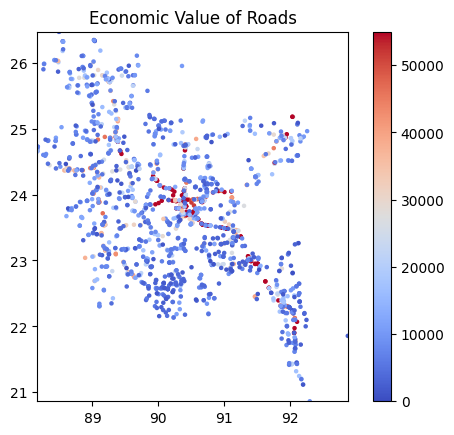

In [108]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Convert latitude and longitude columns to numeric types, handling errors
latlonload['Latitude Decimal'] = pd.to_numeric(latlonload['Latitude Decimal'], errors='coerce')
latlonload['Longitude Decimal'] = pd.to_numeric(latlonload['Longitude Decimal'], errors='coerce')

# Define a small range around lat/lon 0/0
tolerance = 0.01

# Remove rows with latitude and longitude values close to 0/0
latlonload = latlonload[
    (latlonload['Latitude Decimal'].abs() > tolerance) &
    (latlonload['Longitude Decimal'].abs() > tolerance)
]

# Create a GeoDataFrame from the filtered latlonload DataFrame
gdf = gpd.GeoDataFrame(latlonload, geometry=gpd.points_from_xy(latlonload['Longitude Decimal'], latlonload['Latitude Decimal']))

# Get the bounding box of the GeoDataFrame
minx, miny, maxx, maxy = gdf.total_bounds

# Create the base map with the bounding box
ax = plt.axes()
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot the GeoDataFrame with EVV values
gdf.plot(ax=ax, marker='o', markersize=5, column='EVV', cmap='coolwarm', legend=True, vmin=0, vmax=55000)

# Add title and show plot
plt.title('Economic Value of Roads')
plt.show()


In [109]:
latlonload.to_csv('latlonloads.csv')


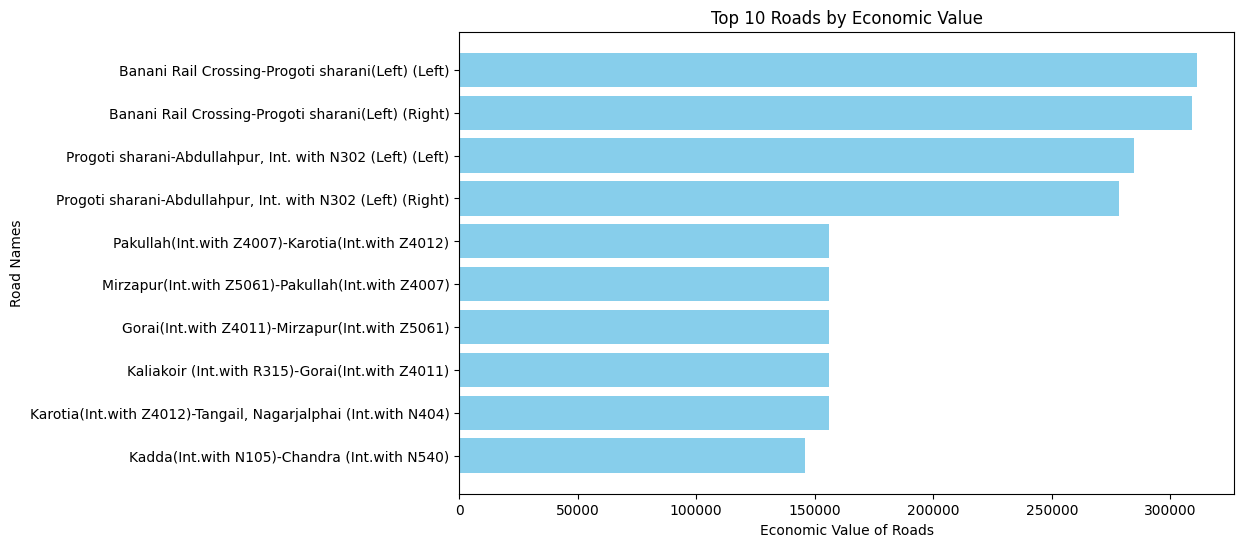

In [112]:
import matplotlib.pyplot as plt

# Sort the DataFrame based on 'EVV' column in descending order
sorted_latlonload = latlonload.sort_values('EVV', ascending=False)

# Get the top N roads (e.g., top 10)
top_n = 10
top_n_df = sorted_latlonload.head(top_n)

# Extract road names and EVV values for plotting
road_names = top_n_df['name']
evv_values = top_n_df['EVV']

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.barh(road_names, evv_values, color='skyblue')
plt.xlabel('Economic Value of Roads')
plt.ylabel('Road Names')
plt.title(f'Top {top_n} Roads by Economic Value')
plt.gca().invert_yaxis()  # Invert y-axis to display the highest-ranking road at the top
plt.show()
